In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import scanpy as sc
from pandas_profiling import ProfileReport
import plotly.express as px
import plotly.io as pio
import sklearn.preprocessing
import umap

pio.renderers.default = "notebook"

In [2]:
data = pd.read_pickle("GEX_values" + '.pkl')

data.shape

(69249, 13431)

In [3]:
data.index

CategoricalIndex(['Naive CD20+ B', 'CD14+ Mono', 'CD8+ T', 'CD8+ T',
                  'CD16+ Mono', 'B1 B', 'Lymph prog', 'CD4+ T naive',
                  'CD4+ T activated', 'B1 B',
                  ...
                  'Naive CD20+ B', 'CD8+ T', 'Naive CD20+ B', 'CD8+ T',
                  'CD8+ T', 'CD8+ T naive', 'Lymph prog', 'CD8+ T', 'cDC2',
                  'Naive CD20+ B'],
                 categories=['B1 B', 'CD4+ T activated', 'CD4+ T naive', 'CD8+ T', 'CD8+ T naive', 'CD14+ Mono', 'CD16+ Mono', 'Erythroblast', ...], ordered=False, dtype='category', name='cell_type', length=69249)

In [4]:
scdata = sc.AnnData(X = data.values)
scdata.obs["cell_type"] = data.index


In [5]:

sc.pp.log1p(scdata)
# sc.pp.pca(scdata)
# sc.pp.neighbors(scdata)
# sc.tl.umap(scdata)

scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(scdata.X)
scaled_data = scaler.transform(scdata.X)

In [6]:
data = pd.DataFrame(scaled_data, index=data.index, columns=data.columns)

In [7]:
# sc.pl.umap(scdata, color = 'cell_type')

In [8]:
# sc.pl.pca(scdata, color = 'cell_type')

In this instance our data instance is an indifidual cell and our label is irrelevent for this simple autoencoder. Nevertheless in future versions it may be useful select a label to pair with our data.

In [9]:
class GEX_Dataset(torch.utils.data.Dataset):
      def __init__(self, data):
          self.data = data
          self.nparray = data.to_numpy()
          
      def __len__(self):
          return len(self.data)
    
      def __getitem__(self, idx):
          return torch.tensor(self.nparray[idx]).type(torch.float32), self.data.index[idx]
    
      
          
          
    

In [10]:
GEX_Dataset = GEX_Dataset(data)

In [11]:
GEX_Dataset[0][0].shape

torch.Size([13431])

In [12]:
def init_layers(layer):
    if type(layer) == nn.Linear:
        torch.nn.init.uniform_(layer.weight -0.08, 0.08)

In [13]:
import platform
platform.platform()

'macOS-10.16-x86_64-i386-64bit'

In [14]:
input_size = data.shape[1] # size of each input
hidden_size = 128 # hidden dimension
latent_size = 10  # latent vector dimension

batch_size = 512
epochs = 20
lr = 1e-4
train_loss = []
log_interval = 20
checkpoints = "/Users/eamonmcandrew/Desktop/Single_cell_integration/checkpoints"

In [15]:
GEX_dataloader = DataLoader(GEX_Dataset, batch_size=batch_size, shuffle=True)

In [16]:
len(GEX_dataloader)

136

In [17]:
if torch.has_mps:
     device = torch.device('mps')

In [18]:
class encoder(nn.Module):
    def __init__(self):
        super(encoder, self).__init__()
        self.encoder_layer_1 = nn.Sequential(
            nn.Linear(input_size, hidden_size), nn.ReLU())
        self.encoder_layer_2_mean = nn.Sequential(nn.Linear(hidden_size, latent_size))
        self.encoder_layer_2_logvar = nn.Sequential(nn.Linear(hidden_size, latent_size))
        
        
        


In [19]:
class decoder(nn.Module):
    def __init__(self):
        super(decoder, self).__init__()
        self.decoder_layer_1 = nn.Sequential(
            nn.Linear(latent_size, hidden_size), nn.ReLU())
        self.decoder_layer_2 = nn.Sequential(nn.Linear(hidden_size, input_size), nn.Sigmoid())
        


In [20]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = encoder()
        self.decoder = decoder()
        self.apply(init_layers)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add(mu)
        
    def forward(self, x):
       x = self.encoder.encoder_layer_1(x)
       log_var = self.encoder.encoder_layer_2_logvar(x)
       mu = self.encoder.encoder_layer_2_mean(x)
       
       z = self.reparameterize(mu, log_var)
       x = self.decoder.decoder_layer_1(z)
       x = self.decoder.decoder_layer_2(x)
       
       return x, mu, log_var


In [21]:
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)

In [22]:
vae.train()


    

VAE(
  (encoder): encoder(
    (encoder_layer_1): Sequential(
      (0): Linear(in_features=13431, out_features=128, bias=True)
      (1): ReLU()
    )
    (encoder_layer_2_mean): Sequential(
      (0): Linear(in_features=128, out_features=10, bias=True)
    )
    (encoder_layer_2_logvar): Sequential(
      (0): Linear(in_features=128, out_features=10, bias=True)
    )
  )
  (decoder): decoder(
    (decoder_layer_1): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
    )
    (decoder_layer_2): Sequential(
      (0): Linear(in_features=128, out_features=13431, bias=True)
      (1): Sigmoid()
    )
  )
)

In [23]:
checkpoints = "/Users/eamonmcandrew/Desktop/Single_cell_integration/checkpoints"

train_kl_loss = []
train_BCE_loss = []

for epoch in range(epochs):
    for batch_idx, (batch, _) in enumerate(GEX_dataloader, 0):
        batch = batch.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = vae(batch)
        BCE_loss = F.binary_cross_entropy(recon_batch, batch)
        log_var_x = torch.clip(torch.exp(log_var), min=1e-5)
        KLD_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var_x)
        loss = BCE_loss + KLD_loss
        # torch.nn.utils.clip_grad_norm_(vae.parameters(), 1)
        loss.backward()
        train_kl_loss.append(KLD_loss.item())
        train_BCE_loss.append(BCE_loss.item())
        train_loss.append(loss.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f'Epoch: {epoch} | Batch: {batch_idx} | KL Loss: {KLD_loss.item()} | BCE Loss: {BCE_loss.item()} | Total Loss: {loss.item()}')
    torch.save(vae.state_dict(), os.path.join(checkpoints, f'vae_epoch_{epoch}.pt'))
    
    

Epoch: 0 | Batch: 0 | KL Loss: 0.0027548419311642647 | BCE Loss: 0.7005496025085449 | Total Loss: 0.7033044695854187
Epoch: 0 | Batch: 20 | KL Loss: 0.00028610971639864147 | BCE Loss: 0.6708623170852661 | Total Loss: 0.671148419380188
Epoch: 0 | Batch: 40 | KL Loss: 0.0005124670569784939 | BCE Loss: 0.6410953402519226 | Total Loss: 0.6416078209877014
Epoch: 0 | Batch: 60 | KL Loss: 0.001207592897117138 | BCE Loss: 0.6109273433685303 | Total Loss: 0.6121349334716797
Epoch: 0 | Batch: 80 | KL Loss: 0.002308369381353259 | BCE Loss: 0.5795775651931763 | Total Loss: 0.5818859338760376
Epoch: 0 | Batch: 100 | KL Loss: 0.0038440339267253876 | BCE Loss: 0.5509585738182068 | Total Loss: 0.5548025965690613
Epoch: 0 | Batch: 120 | KL Loss: 0.0050530750304460526 | BCE Loss: 0.5181564688682556 | Total Loss: 0.5232095718383789
Epoch: 1 | Batch: 0 | KL Loss: nan | BCE Loss: 0.687465488910675 | Total Loss: nan
Epoch: 1 | Batch: 20 | KL Loss: nan | BCE Loss: 0.6865015625953674 | Total Loss: nan
Epoch: 

KeyboardInterrupt: 

In [ ]:
def plot_loss(train_loss):
    fig = plt.figure(figsize=(10, 5))
    plt.plot(train_loss)
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.show()

In [ ]:
def plot_KLD_loss(train_kl_loss):
    fig = plt.figure(figsize=(10, 5))
    plt.plot(train_kl_loss)
    plt.xlabel('Batch')
    plt.ylabel('KLD Loss')
    plt.show()

In [ ]:
plot_KLD_loss(train_kl_loss)

NameError: name 'train_kl_loss' is not defined

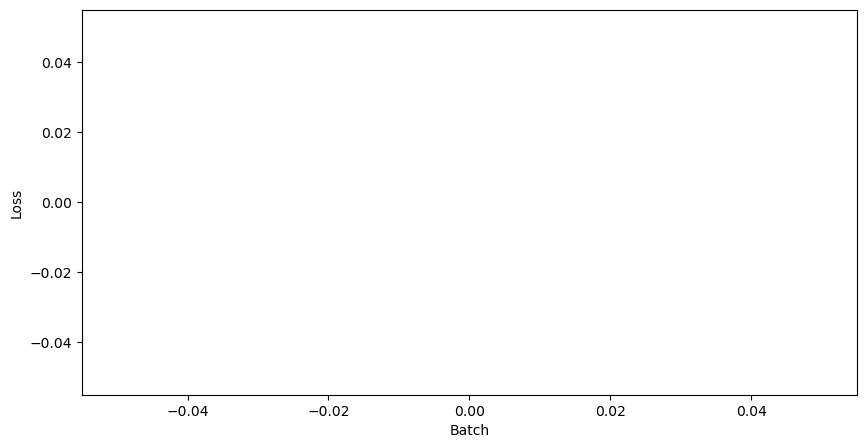

In [ ]:
plot_loss(train_loss)

In [ ]:
vae.eval()

VAE(
  (encoder): encoder(
    (encoder_layer_1): Sequential(
      (0): Linear(in_features=13431, out_features=128, bias=True)
      (1): ReLU()
    )
    (encoder_layer_2_mean): Sequential(
      (0): Linear(in_features=128, out_features=10, bias=True)
    )
    (encoder_layer_2_logvar): Sequential(
      (0): Linear(in_features=128, out_features=10, bias=True)
    )
  )
  (decoder): decoder(
    (decoder_layer_1): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
    )
    (decoder_layer_2): Sequential(
      (0): Linear(in_features=128, out_features=13431, bias=True)
      (1): Sigmoid()
    )
  )
)

In [ ]:
def load_checkpoint(model, optimizer, filename):
    print(f'Loading checkpoint {filename} for model {model}')
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return checkpoint

In [ ]:
load_checkpoint(vae, optimizer, os.path.join(checkpoints, 'vae_epoch_18.pt'))

Loading checkpoint /Users/eamonmcandrew/Desktop/Single_cell_integration/checkpoints/vae_epoch_18.pt for model VAE(
  (encoder): encoder(
    (encoder_layer_1): Sequential(
      (0): Linear(in_features=13431, out_features=128, bias=True)
      (1): ReLU()
    )
    (encoder_layer_2_mean): Sequential(
      (0): Linear(in_features=128, out_features=10, bias=True)
    )
    (encoder_layer_2_logvar): Sequential(
      (0): Linear(in_features=128, out_features=10, bias=True)
    )
  )
  (decoder): decoder(
    (decoder_layer_1): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
    )
    (decoder_layer_2): Sequential(
      (0): Linear(in_features=128, out_features=13431, bias=True)
      (1): Sigmoid()
    )
  )
)


KeyError: 'state_dict'

In [ ]:
def sample_latent_space(vae, n=10000):
    with torch.no_grad():
        z = torch.randn(n, latent_size).to(device)
        samples = vae.decoder.decoder_layer_2(vae.decoder.decoder_layer_1(z))
        samples = samples.cpu().numpy()
        return samples

In [ ]:
def get_embeddings(vae, dataloader):
    with torch.no_grad():
        embeddings = []
        for batch, _ in dataloader:
            batch = batch.to(device)
            _, mu, _ = vae(batch)
            embeddings.append(mu.cpu().numpy())
        embeddings = np.concatenate(embeddings)
        return embeddings

In [ ]:
embeddings = get_embeddings(vae, GEX_dataloader)

In [ ]:
dataframe = pd.DataFrame(embeddings, index=data.index)


In [ ]:
dataframe

0         1         2         3         4         5  \
cell_type                                                                   
Naive CD20+ B -0.260933  0.251580 -0.142152 -0.262763 -0.171936  0.059774   
CD14+ Mono     0.190045  0.288743  0.150997 -0.072552  0.274329 -0.081779   
CD8+ T        -0.143725  0.144964 -0.064718 -0.139128  0.222065  0.062428   
CD8+ T        -0.162485  0.198940 -0.031916 -0.236621  0.182398  0.126526   
CD16+ Mono     0.406695  0.625527  0.356972 -0.365041  0.326875 -0.409985   
...                 ...       ...       ...       ...       ...       ...   
CD8+ T naive   0.194391  0.011130 -0.095530 -0.490263  0.653205 -0.122303   
Lymph prog    -0.183755 -0.137195 -0.278722 -0.363193  0.498572 -0.150945   
CD8+ T         0.021999  0.220028 -0.025836 -0.090970  0.125565 -0.060505   
cDC2           0.094461  0.303457  0.139640  0.018855  0.223465  0.041520   
Naive CD20+ B -0.225804  0.251125  0.085145  0.030417  0.118805  0.054418   

                      6         7         8         9  
cell_type                                              
Naive CD20+ B  0.163131  0.056233 -0.377576 -0.198057  
CD14+ Mono    -0.039218  0.100223 -0.006256 -0.081752  
CD8+ T        -0.046874 -0.122598 -0.049744  0.116420  
CD8+ T         0.081084  0.270697 -0.055824  0.174391  
CD16+ Mono    -0.238963  0.751646 -0.340666 -0.135987  
...                 ...       ...       ...       ...  
CD8+ T naive  -0.163754 -0.134032 -0.238905 -0.092275  
Lymph prog    -0.165577  0.059515 -0.333007  0.028161  
CD8+ T        -0.137027  0.073073  0.012998  0.089455  
cDC2          -0.097357 -0.026219 -0.031275  0.235503  
Naive CD20+ B -0.282027  0.141935 -0.137961  0.369714  

[69249 rows x 10 columns]

In [ ]:
def plot_embeddings(dataframe, color_by=None, title=None):
    fig = px.scatter(dataframe, x=0, y=1, color=color_by, title=title)
    fig.show()
    
   
    

In [ ]:
plot_embeddings(dataframe, color_by=dataframe.index, title='Cell type')

In [ ]:
umap_embeddings = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='correlation').fit_transform(dataframe)

In [ ]:
def plot_umap_embeddings(umap_embeddings, color_by=None, title=None):
   px.scatter(umap_embeddings, x=0, y=1, color=color_by, title=title).show()

In [ ]:
plot_umap_embeddings(umap_embeddings, color_by=dataframe.index, title='Cell type')

In [ ]:
sc.pp.neighbors(sample)

NameError: name 'sample' is not defined

In [ ]:
sc.tl.umap(sample)

In [ ]:
sc.pl.umap(sample)